# Initial experiments: Raster, sequence pairs

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from dataset import QuickDrawDataset
from utils import AbsolutePenPositionTokenizer
from tqdm import tqdm
import pickle

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)

Using device: cuda


In [6]:
import pyvips
from io import BytesIO
from PIL import Image


def svg_rasterize(svg_string: str, size=(64, 64)) -> Image.Image:
    svg_bytes = svg_string.encode("utf-8")
    image = pyvips.Image.svgload_buffer(svg_bytes)
    image = image.flatten(background=0xFFFFFF)
    png_bytes = image.write_to_buffer(".png")
    img = Image.open(BytesIO(png_bytes)).convert("L")
    img = img.resize(size)
    tensor = torch.tensor(list(img.getdata()), dtype=torch.float32)
    tensor = tensor.view(size[1], size[0]) / 255.0
    return tensor


labels = ["cat"]

training_data = QuickDrawDataset(labels=labels, download=True)

tokenizer = AbsolutePenPositionTokenizer(bins=64)


class SketchReconDataset(Dataset):
    def __init__(
        self,
        svg_list,
        tokenizer,
        max_len=200,
        cache_file="sketch-im_tokenized_dataset.pkl",
    ):
        self.data = []
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_id = tokenizer.vocab["PAD"]

        # Try to load from cache
        try:
            with open(cache_file, "rb") as f:
                self.data = pickle.load(f)
            print(f"Loaded tokenized data from {cache_file}")
        except FileNotFoundError:
            for svg in tqdm(svg_list, desc="Tokenizing SVGs"):
                tokens = tokenizer.encode(svg)[:max_len]
                tokens = tokens + [self.pad_id] * (max_len - len(tokens))
                image = svg_rasterize(svg)
                self.data.append((tokens, image))

            with open(cache_file, "wb") as f:
                pickle.dump(self.data, f)
            print(f"Saved tokenized data to {cache_file}")

    def __getitem__(self, idx):
        seq, image = self.data[idx]
        input_ids = torch.tensor(seq[:-1])
        target_ids = torch.tensor(seq[1:])
        return image, input_ids, target_ids

    def __len__(self):
        return len(self.data)


dataset = SketchReconDataset(training_data, tokenizer, max_len=200)

Loading QuickDraw files: 1it [00:03,  3.38s/it]


Loaded tokenized data from sketch-im_tokenized_dataset.pkl


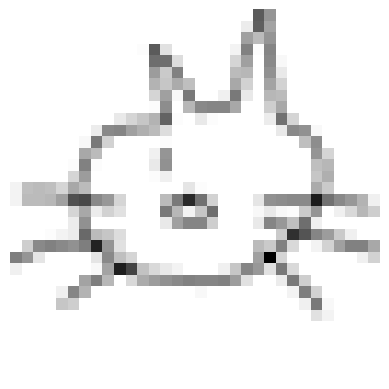

In [ ]:
image, input_ids, target_ids = dataset[0]

image = (image * 255).byte()

# show image
image = image.numpy()

import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

In [1]:
%pip install piq

Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
from torch.utils.data import DataLoader
from piq import FID

class SketchImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx][0]
    
sketch_images = SketchImageDataset(dataset)

first_dl, second_dl = DataLoader(sketch_images, shuffle=True), DataLoader(sketch_images)
fid_metric = FID()
first_feats = fid_metric.compute_feats(first_dl)
second_feats = fid_metric.compute_feats(second_dl)
fid: torch.Tensor = fid_metric(first_feats, second_feats)

print(f"FID: {fid:0.4f}")



c:\Users\matth\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matth\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\matth\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to C:\Users\matth/.cache\torch\hub\checkpoints\pt_inception-2015-12-05-6726825d.pth


100%|██████████| 91.2M/91.2M [00:03<00:00, 24.2MB/s]
c:\Users\matth\AppData\Local\Programs\Python\Python313\Lib\site-packages\piq\base.py:44: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  images = batch['images']


IndexError: too many indices for tensor of dimension 3

In [ ]:
gs: torch.Tensor = piq.GS(sample_size=64, num_iters=100, i_max=100, num_workers=4)(x_features, y_features)
print(f"GS: {gs:0.4f}")